## Purpose of project
This project investigates how strategic feature engineering can enhance data precision and model accuracy so that customer churn signals are identified early in the customer life cycle and that interventions can be made before customers decide to leave.

## Question that is being answered:  
"How early can we predict customer churn, and which features are most indicative of early churn risk?"

## The data:
The sample dataset tracks a fictional telco company's customer churn based on various factors. The churn column indicates whether the customer departed within the last month. Other columns include gender, dependents, monthly charges, and many with information about the types of services each customer has.

## Data Source:
https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset

Activate the customer_churn virtual env and run jupyter notebook

# In this notebook:
1. Data import
2. split test set 
3. Exploratory data analysis


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

from scipy.stats import ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

In [74]:
import os
print(os.getcwd())
os.chdir('/Users/Rime/Documents/Projects/customer-churn/')
print(os.getcwd())

/Users/Rime/Documents/Projects/customer-churn
/Users/Rime/Documents/Projects/customer-churn


## Import data

In [75]:
def get_data(url):
    
    try:
        data = pd.read_csv(url)
        print('Data downloaded successfully')
    except Exeption as e:
        print(f'Could not download data: {str(e)}')
    
    return data

In [76]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/refs/heads/master/data/Telco-Customer-Churn.csv'

df_org = get_data(url)

Data downloaded successfully


In [77]:
#save file
df_org.to_csv('data/telco_customer_churn.csv', index=False)

In [78]:
#make a copy of the dataframe
df_org = df_org.copy()
df_org.shape

(7043, 21)

In [79]:
df_org.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [80]:
#look at the numerical columns
df_org.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [81]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [82]:
#List the columns
df_org.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

There are only tow numeric columns, tenure, monthly charge and total charge.

Next explore if there are nay missing values

In [83]:
df_org.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Explore the response variable (Churn)

In [84]:
df_org['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

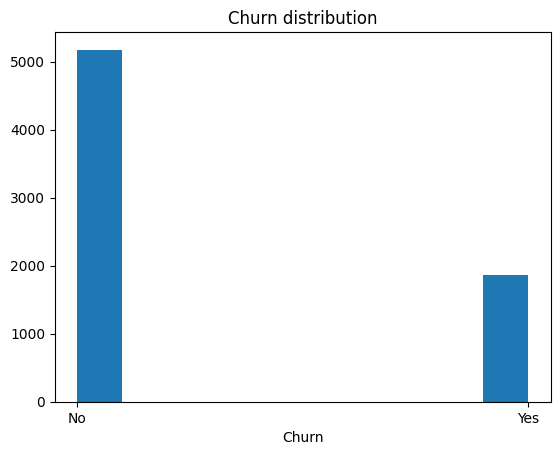

In [85]:
plt.hist(df_org['Churn'])
plt.xlabel('Churn')
plt.title('Churn distribution');

### Scores to consider
- The data is imbalanced, 73% to 26% 
- Since churn is being predicted, recall is important because it measures how many churners are identified, so use this metric if the cost of churners is too high
- recall has to be balanced with precision to avoid having too many false alarms
- f1 score is a good choice because it balanced precision and recall and I think it is a good choice for this project.

## Test set 
- Create test set to avoid data leakage while exploring the data

In [86]:
train, test = train_test_split(df_org,test_size=0.2,random_state=42)
train.shape, test.shape, df_org.shape

((5634, 21), (1409, 21), (7043, 21))

In [87]:
#save test set
test.to_csv('data/test_data.csv',index=False)
train.to_csv('data/orginal_train_data.csv',index=False)

## Data Cleaning and Exploration

In [88]:
#make a copy of data
df_train = train.copy()
df_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2142,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8,No
1623,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No
6074,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45,Yes
1362,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95,Yes
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


### Data Cleaning

In [89]:
#data cleaning
def data_exploration(df, features):
    '''retruns:
        number of missing values
        the number of unique values in each column
    '''
    #print if there are missing values
    print(f'Number of missing values: \n{df.isna().sum()}\n{df.info()}')
    #print(df.info() )
    for feature in features:
        print(f"\nfeature:{feature}: has {df[feature].nunique()} unique values \n values:{df[feature].unique()}")

In [90]:
#run data exploration function
data_exploration(df_train, df_train.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 2142 to 860
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 
 17

There are three numeric columns: tenure, monthlyCharges and totalCharges
The rest either binary or categorical with more than two values.

## Investigate
Columns: MultipleLines and PhoneService should align, meaning that if no PhoneService then MultipleLines should be No phone service.

Columns:InternetService, OnlineSecurity, OnlineBackup,DeviceProtection,TechSupport, StreamingTV, if one has the value `no internet service` then they all should have the same value

- Check if when PhoneService is no then MultipleLines is No phone service.

In [91]:
#print the size of phone service = No and the size of multipipelines = No phone service
df_train[df_train['PhoneService']=='No'].shape, df_train[df_train['MultipleLines']=='No phone service'].shape
print(f"Size of Phone service = No is: {df_train[df_train['PhoneService']=='No'].shape}\n\
Size of Multipipelines = No phone service is: {df_train[df_train['MultipleLines']=='No phone service'].shape}")

Size of Phone service = No is: (552, 21)
Size of Multipipelines = No phone service is: (552, 21)


In [92]:
#check values align for  MultipleLines and PhoneService 
noPhone_inconsistancy = df_train[(df_train['PhoneService']!='No') & (df_train['MultipleLines']=='No phone service')]
Phone_inconsistancy = df_train[(df_train['PhoneService']=='No') & (df_train['MultipleLines']!='No phone service')]
print(f'inconsistencies = {noPhone_inconsistancy.shape, Phone_inconsistancy.shape}')

inconsistencies = ((0, 21), (0, 21))


In [93]:
Phone_inconsistancy = df_train[(df_train['PhoneService']=='No') & (df_train['MultipleLines']=='No phone service')]
Phone_inconsistancy.shape, (df_train[['PhoneService']]=='No').shape, (df_train[['MultipleLines']]=='No phone service').shape

((552, 21), (5634, 1), (5634, 1))

Check that InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV should all say No internet service

In [94]:
#size of InternetService=No and OnlineSecurity = 'No internet service
df_train[df_train['InternetService']=='No'].shape,df_train[df_train['OnlineSecurity']=='No internet service'].shape

((1214, 21), (1214, 21))

In [95]:
#df with InternetService ='No
no_internet_df = df_train[df_train['InternetService']=='No']
no_internet_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2722,4635-EJYPD,Male,0,Yes,Yes,32,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.95,613.95,No
4006,2607-DHDAK,Male,0,Yes,Yes,72,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.80,1414.65,No
5466,0221-NAUXK,Male,0,No,Yes,10,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),19.95,219.5,No
4166,5917-RYRMG,Male,1,No,No,32,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.80,587.7,No
1323,4565-NLZBV,Female,0,Yes,No,71,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),24.65,1710.15,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5311,8053-WWDRO,Female,0,Yes,No,6,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),19.50,146.3,Yes
3171,8908-SLFCJ,Female,0,No,No,21,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),20.85,435.25,No
5578,8215-NGSPE,Female,0,Yes,Yes,42,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,833.55,No
5226,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No


In [96]:
#There should be 1214 No internet service 
cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV']
for col in cols:
    print((no_internet_df[col] == 'No internet service').sum())
     

1214
1214
1214
1214
1214


In [97]:
#Check if there is any No internet service when InternetService is yes
cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV']
for col in cols:
    print(((df_train['InternetService'] == 'Yes') & df_train[col] == 'No internet service').sum())


0
0
0
0
0


Values match

## Fixing data types of columns

`TotalCharges` is of type object instead of numeric which means that there is a value that is not a number in the column, so use to_numeric function and use coerce for error to get nans for non numeric entries

In [98]:
df_train['TotalCharges'] = df_train['TotalCharges'].apply(pd.to_numeric, errors='coerce')
df_train['TotalCharges'].isna().sum()

np.int64(10)

There are 10 Nas in the TotalCharges. Let's see the missing values

In [99]:
#let's take a look
df_train[['tenure','MonthlyCharges']].loc[df_train['TotalCharges'].isna()]

,tenure,MonthlyCharges
6754,0,61.90
1340,0,56.05
3826,0,25.35
5218,0,19.70
3331,0,19.85
936,0,80.85
753,0,20.25
4380,0,20.00
488,0,52.55
1082,0,25.75


In [100]:
#Nas is when tenure is 0, let's double check
df_train[['tenure','MonthlyCharges']].loc[df_train['tenure']==0]

,tenure,MonthlyCharges
6754,0,61.90
1340,0,56.05
3826,0,25.35
5218,0,19.70
3331,0,19.85
936,0,80.85
753,0,20.25
4380,0,20.00
488,0,52.55
1082,0,25.75


So nas in totalcharge is probably customers that canceled right away so they were not billed so it is safe to replace the nans with 0


In [101]:
df_train['TotalCharges']=df_train['TotalCharges'].fillna(0)
#change column to numeric
df_train['TotalCharges'] = df_train['TotalCharges'].apply(pd.to_numeric)

In [121]:
#run describe again
df_train.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5634.000000,5634.000000,5634.000000,5634.000000
mean,0.160809,32.373092,64.864253,2287.087948
std,0.367388,24.424539,30.089324,2263.197899
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.750000,406.275000
50%,0.000000,29.000000,70.525000,1405.650000
75%,0.000000,55.000000,89.937500,3806.612500
max,1.000000,72.000000,118.600000,8684.800000


### Investigate target ==> Churn

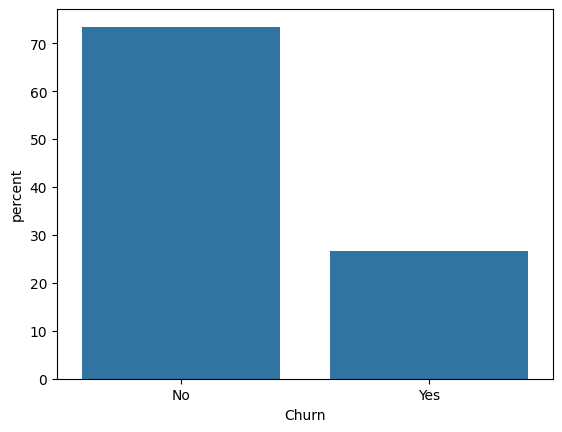

In [102]:
sns.countplot(data=df_train, x='Churn', stat='percent')
plt.show()

This is an imbalanced dataset that is 70%/30% no/yes

### Save training data 

In [103]:
#df_train.to_pickle('train.pkl')
#df_copy = df_copy.drop('discount', axis=1)
#df_copy['churn'] = target

df_train.to_csv('data/clean_train_data.csv', index=False)
#test
pd.read_csv('data/clean_train_data.csv')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.80,No
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No
2,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45,Yes
3,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95,Yes
4,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,0.00,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,Yes,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95.00,Yes
5630,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.30,No
5631,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,No
5632,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,Yes


_____________

## Run RandomForestClassifier model on original clean data
- this is to have a baseline value to compare to to measure how much feature addition improves the model
  #### Steps:
- create a custome feature feature processor
- wrap it in a CustomFeatureProcessor  
  - This class that will have a fit and transform methods so that it is compatible with scikit learn's pipeline method. This class is important when I am running cross validation where scikit learn calls fit and transform on each fold. It also prevents data leakage between the test set and the validation sets and makes the function compatible with hyper parameter tuning tools like GridSearch and allows for tracking parameters
- use Stratified k-fold which insures that the class distribution in the test and validation sets matches that of the original data, which kfold validation does not. Since the dataset is imbalaced this will creates more representative samples
- Cross validation


Load Data

In [104]:
train_df_org = pd.read_csv('data/clean_train_data.csv')
train_df_org.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.80,No
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No


- create a function that encodes and scales the data that I can reuse

In [105]:
def extract_target(data):
    '''
    input: cleaned data
    output: maps target values with 1 and 0 and returns the mapped target
    '''
    y = data['Churn'].map({'Yes':1,'No':0})
    return y
    
def scale_encode_data(data, kmeans=False):
    '''
    Transforms data by scaling numeric features and encoding non_numeric features
    
    Parameters: cleaned_data
    Returns: scaled data with customerID and Churn dropped
    '''
    data = data.copy()
    data = data.drop(['customerID','Churn'], axis=1)
    
    non_num_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies','Contract', 'PaymentMethod']
    
    non_numeric_dummies =(pd.get_dummies(data[non_num_cols], drop_first=True)).astype(int) #get_dummies gives  binary features
    #change values to numeric 
    #dummies_num = non_numeric_dummies.astype(int)

    #concat to original dataframe and drop non-numeric original columns
    data = pd.concat([data.drop(non_num_cols,axis=1),non_numeric_dummies],axis=1)
    data= data.reset_index(drop = True)

    #map other binary features 
    data['gender'] = data['gender'].map({'Male':1,'Female':0})
    data['Partner'] = data['Partner'].map({'Yes':1,'No':0})
    data['Dependents'] = data['Dependents'].map({'Yes':1,'No':0})
    data['PhoneService'] = data['PhoneService'].map({'Yes':1,'No':0})
    data['PaperlessBilling'] = data['PaperlessBilling'].map({'Yes':1,'No':0})

    
    #scale numeric features
    scaler=StandardScaler()
    
    scaled_df = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
   
      
    
    return scaled_df

In [106]:
df = scale_encode_data(train_df_org)

In [107]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.025166,-0.437749,-0.969579,1.532186,-0.465683,0.329573,-1.200007,-0.000474,-0.419925,-0.329573,...,-0.637763,-0.524081,-0.794748,-0.524081,1.250762,1.910109,-0.558353,-0.527656,-0.709650,1.84247
1,-1.025166,-0.437749,-0.969579,-0.652662,0.885537,0.329573,0.833328,1.074754,1.256017,-0.329573,...,-0.637763,-0.524081,1.258260,-0.524081,1.250762,-0.523530,1.790982,-0.527656,-0.709650,-0.54275
2,0.975452,-0.437749,1.031376,-0.652662,-1.284605,-3.034225,0.833328,-1.376499,-1.000283,3.034225,...,-0.637763,-0.524081,-0.794748,-0.524081,-0.799513,-0.523530,-0.558353,-0.527656,1.409146,-0.54275
3,0.975452,-0.437749,-0.969579,-0.652662,-1.161766,0.329573,0.833328,0.177346,-0.905497,-0.329573,...,-0.637763,-0.524081,-0.794748,-0.524081,-0.799513,-0.523530,-0.558353,-0.527656,1.409146,-0.54275
4,0.975452,-0.437749,-0.969579,1.532186,-1.325551,0.329573,0.833328,-0.098524,-1.010646,-0.329573,...,1.567981,-0.524081,-0.794748,-0.524081,-0.799513,-0.523530,1.790982,-0.527656,-0.709650,-0.54275


In [108]:
class CustomFeatureProcessor(BaseEstimator, TransformerMixin):
    '''
    Create a custom transformer for the scale_encode_data function by
    inheriting from the two base classes to create a scikit learn compatible transformer, 
    they provide necessary methods to work with the pipeline API
    
    '''
    def __init__(self, processing_func,kmeans=False ):
        self.processing_func = processing_func
        self.kmeans = kmeans

    def fit(self, X, y=None):
        #y=None allows the transformer to be used in supervised and unsupervised 
        return self

    def transform(self, X, y=None):
        # should handle data processing and return X, y
        X_processed = self.processing_func(X, kmeans = self.kmeans)
        return X_processed

In [109]:
#Process data
def evaluate_model(data, processing_func):
    '''
    Evaluate RandomForest using a custom processing function

    parameters: 
        pandas df: cleaned IBM churn data
        feature processing function that takes the data and returns scaled, encoded data
    Returns:
        dict: cross-validation results
    '''
    #target variable
    y = extract_target(data)
    
    #create a pipeline with feature processing
    pipeline = Pipeline([
                    ('processor',CustomFeatureProcessor(processing_func)),
                    ('classifier',RandomForestClassifier(random_state=42))
        ])

    #stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {'precision':make_scorer(precision_score),
                'recall':make_scorer(recall_score),
                'f1_score':make_scorer(f1_score),
              'auc_score':make_scorer(roc_auc_score)
              } 
    
    #cross validation
    cv_results = cross_validate(pipeline, data, y, cv=skf, scoring=scoring)

    
    return cv_results

### Run evaluate_model function


In [110]:
org_metrics = evaluate_model(train_df_org, scale_encode_data)
org_metrics

{'fit_time': array([0.79799604, 0.56900191, 0.57803988, 0.87264705, 0.84414697]),
 'score_time': array([0.04878998, 0.04583383, 0.05543804, 0.0939312 , 0.08099198]),
 'test_precision': array([0.635     , 0.66976744, 0.63402062, 0.6367713 , 0.64473684]),
 'test_recall': array([0.42474916, 0.48160535, 0.41137124, 0.47333333, 0.4916388 ]),
 'test_f1_score': array([0.50901804, 0.56031128, 0.4989858 , 0.54302103, 0.55787476]),
 'test_auc_score': array([0.66829246, 0.69792828, 0.66281122, 0.68769448, 0.69684721])}

### Create a dataframe to store all metrics values

In [111]:
features_metrics = pd.DataFrame(columns=['feature_set',
                                         'precision_mean',
                                        'precision_std',
                                        'recall_mean',
                                        'recall_std',
                                        'f1score_mean',
                                        'f1score_std', 
                                        'AUC_mean',
                                        'AUC_std'])#, index=[0])


print(len(features_metrics))
features_metrics

0


,feature_set,precision_mean,precision_std,recall_mean,recall_std,f1score_mean,f1score_std,AUC_mean,AUC_std


### Create a function that adds a new row of metrics to the dataframe

In [112]:
def metric_calcualation(cv_scores,metrics_dict, colname):
    '''
    Adds a new row of metrics to the metrics dataframe
    parameters:
    the scores from running the model on the dataset, the dataframe where all the metrics are stored, and the number of the features added
    returns:
    the metrics dataframe with the new row added
    '''
    new_row = {
        'feature_set':'org_data',
        'precision_mean':float(round(np.mean(cv_scores['test_precision']),4)),
        'precision_std':float(round(np.std(cv_scores['test_precision']),4)),
        'recall_mean':float(round(np.mean(cv_scores['test_recall']),4)),
        'recall_std':float(round(np.std(cv_scores['test_recall']),4)),
        'f1score_mean':float(round(np.mean(cv_scores['test_f1_score']),4)),
        'f1score_std' : float(round(np.std(cv_scores['test_f1_score']),4)),
        'AUC_mean' : float(round(np.mean(cv_scores['test_auc_score']),4)),
        'AUC_std' : float(round(np.std(cv_scores['test_auc_score']),4)) 
         }
    idx = len(features_metrics)+1
    for k,v in new_row.items():
        features_metrics.loc[idx,k]=v
    return features_metrics
features_metrics = metric_calcualation(org_metrics,features_metrics,'orginal_data')
features_metrics

,feature_set,precision_mean,precision_std,recall_mean,recall_std,f1score_mean,f1score_std,AUC_mean,AUC_std
1,org_data,0.6441,0.0134,0.4565,0.0322,0.5338,0.0253,0.6827,0.0146


In [113]:
#save the metrics df
features_metrics.to_pickle('data/metrics_df.pkl')

### Feature Importance

In [114]:
data_transformer= CustomFeatureProcessor(scale_encode_data)
df_org_encoded = data_transformer.transform(train_df_org)
y = extract_target(train_df_org)

In [115]:
rf = RandomForestClassifier(random_state=42)
rf.fit(df_org_encoded, y)


RandomForestClassifier(random_state=42)

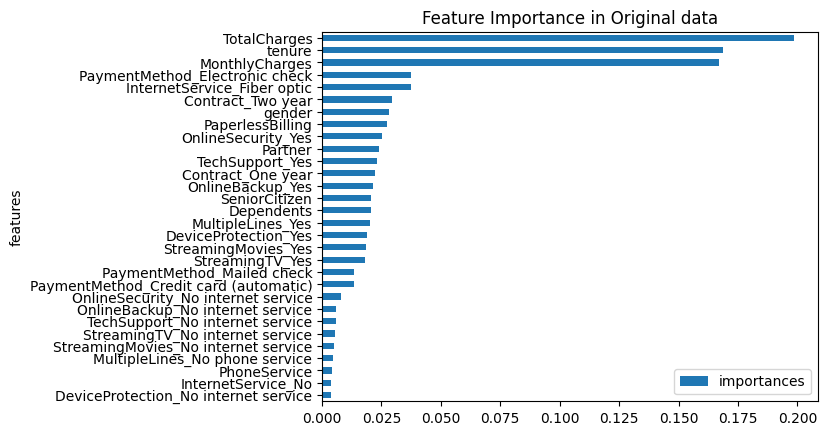

In [116]:
importances = rf.feature_importances_
feature_names = df_org_encoded.columns.tolist()
imp_df = pd.DataFrame({'features':feature_names,
              'importances':importances
             }).sort_values(by='importances', ascending=True)
imp_df.plot(kind='barh',y='importances',x='features', )
plt.title('Feature Importance in Original data')
plt.show()

- The most important features in the original data are:  
      1. TotalCharges  
      2. tenure  
      3. MonthlyCharges  

## Data Exploration
- create a function that prints the types and values of all columns

In [117]:
data_exploration(df_train,df_train.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 2142 to 860
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 
 17

## Explore Numeric Variables
- tenure
- MonthlyCharges
- TotalCharges

### Plot numerial variables vs churn 
To be able to plot numerical variables they have to be scaled columns are on different scales, tenure is in months where as total charge is in dollars

In [118]:
#create a df with only numeric features
num_cols = ['tenure','MonthlyCharges','TotalCharges','Churn']
num_df = df_train[num_cols].copy()

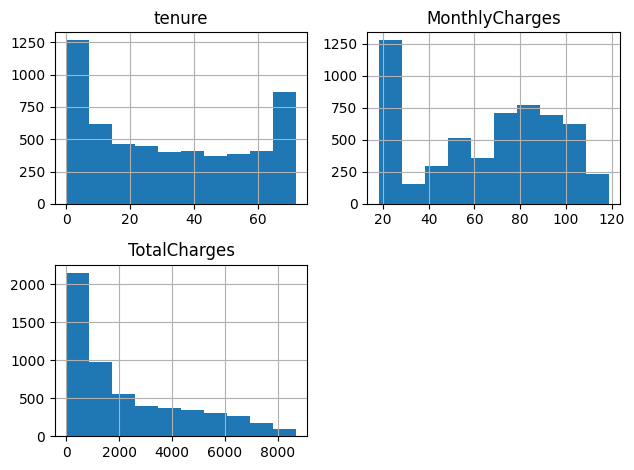

In [119]:
#Plot numeric variables's distribution
num_df.hist()
plt.tight_layout()
plt.show()

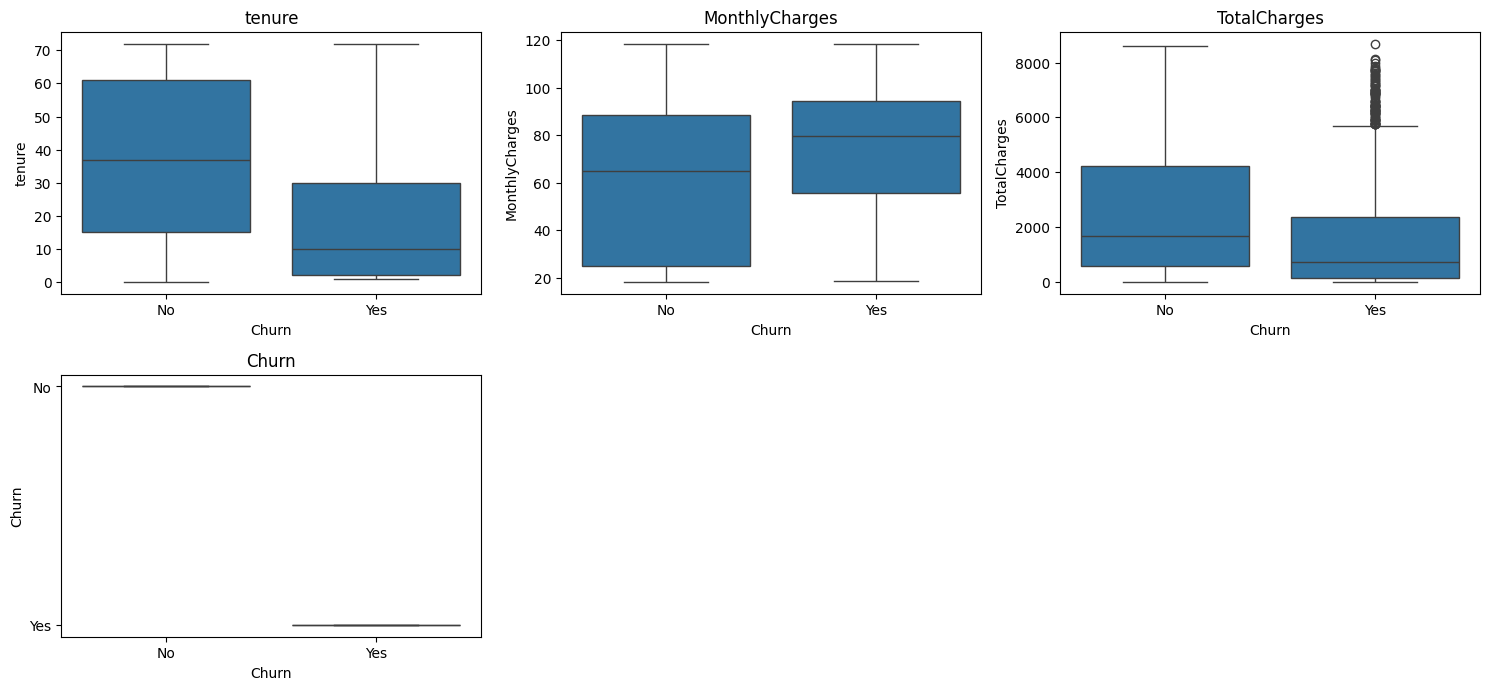

In [120]:
plt.figure(figsize=(15,10))
for i,col in enumerate(num_df.columns):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=num_df,x=num_df['Churn'],y=col)
    plt.title(col)
    plt.tight_layout()

- Customers that churn have lower tenure and higher monthly charges 